# Compare GM outputs from notebook and odc-stats

In [1]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import os
from odc.stats.plugins.gm import StatsGMS2
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct
from odc.geo.geobox import GeoBox

### 1. Create Tasks

In [ ]:
# Function to save task with odc-stats
def save_tasks(cloud_cover, output_db):
    dataset_filter = json.dumps({"cloud_cover": [0, cloud_cover]})
    
    !uv run odc-stats save-tasks \
        --frequency "annual" \
        --grid "EPSG:6933;10;5000" \
        --year "2024" \
        --input-products "s2_l2a" \
        --dataset-filter='{{"cloud_cover": [0,{cloud_cover}]}}' \
        {output_db}

In [ ]:
# Execute save_tasks
save_tasks(60, "s2_l2a_2024--P1Y.db")

### 2. Explore Task

In [ ]:
# Load task
grid = gpd.read_file("s2_l2a_2024--P1Y-2024--P1Y.geojson")

In [ ]:
# Show task interactively, used to pick test tile
grid.explore(
    color="blue",
    style_kwds={"fillOpacity": 0.2, "weight": 0.5, "color": "blue"}
)

## Accessing task database

In [2]:
# define x, y index and year, which has to be aligned with what's used in odc-stats save-tasks

x, y = 211, -1
year = "2024--P1Y"
cloud_filters= {"cloud shadows":[["dilation", 5]], "cloud medium probability":[["opening", 5], ["dilation", 5]], "cloud high probability":[["opening", 5], ["dilation", 5]], "thin cirrus":[["dilation", 5]]}

In [3]:
# Dummy product to pass to taskreader
name, version = 'gm_s2', '0-0-1'
product = OutputProduct(name=name,
                        version=version,
                        short_name=name,
                        location = "",
                        properties = {},
                        measurements = [],
                       )

tidx = (year, x, y)
rdr = TaskReader("s2_l2a_2024--P1Y.db", product=product)
task = rdr.load_task(tidx)
task

Task(product=OutputProduct(name='gm_s2', version='0-0-1', short_name='gm_s2', location='', properties={}, measurements=[], href='https://collections.dea.ga.gov.au/product/gm_s2', region_code_format='x{x:02d}y{y:02d}', cfg=None, naming_conventions_values='dea_c3', explorer_path='https://explorer.dea.ga.gov.au/', inherit_skip_properties=None, preview_image_ows_style=None, classifier='level3', maturity='final', collection_number=3, nodata=None), tile_index=(211, -1), geobox=GeoBox((5000, 5000), Affine(10.0, 0.0, 10550000.0,
       0.0, -10.0, 0.0), CRS('EPSG:6933')), time_range=DateTimeRange(datetime.datetime(2024, 1, 1, 0, 0), '1Y'), uuid=UUID('fcd8aa22-9d53-5dc6-a343-047f68bfc51d'))

## Compare datasets in Task to datasets within Database

In [ ]:
import datacube

# Connect to ODC
dc = datacube.Datacube(app="geomad_s2")

In [ ]:
sentinel2_datasets = dc.find_datasets(
    product=["s2_l2a"],
    time="2024",
    like=task.geobox.to_crs("EPSG:6933"),
    cloud_cover=(0, 60),
)

In [ ]:
# expect same number of datasets found
len(task.datasets), len(sentinel2_datasets)

## Visualise Tile

In [ ]:
# Load available data
ds = dc.load(
    datasets=sentinel2_datasets,
    geopolygon=task.geobox.extent,  
    measurements=["red", "green", "blue", "scl"],
    dask_chunks={"x": 5000, "y": 5000, "time":-1},
    resolution=(-10,10),
    group_by="solar_day",
    output_crs=task.geobox.crs, #"EPSG:6933"
    driver="rio",
)

In [ ]:
# expect same number of days for this tile in s2_l2a_2024--P1Y.csv
ds

In [ ]:
task.geobox.explore()

## Process Data with ODC Stats Run

In [4]:
tile_id = f"{year}/{x:+04d}/{y:+04d}"
output_dir = os.path.abspath("./output")
file_url_output = f"file://{output_dir}"

In [5]:
!uv run odc-stats run \
    --plugin="gm-s2" \
    --plugin-config="../config/geomad_config/plugin_config.yaml" \
    --config="../config/geomad_config/main_config.yaml" \
    --threads=5 \
    --memory-limit="40Gi" \
    --location="{file_url_output}" \
    s2_l2a_2024--P1Y.db \
    {tile_id}

I0000 00:00:1768817264.452421    9694 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
[2026-01-19 10:07:44,467] {_cli_run.py:171} INFO - Config overrides: {'filedb': 's2_l2a_2024--P1Y.db', 'plugin': 'gm-s2', 'threads': 5, 'memory_limit': '40Gi', 'output_location': 'file:///home/jovyan/Indonesia-GeoMAD/notebook/output'}
[2026-01-19 10:07:44,467] {_cli_run.py:203} INFO - Using this config: TaskRunnerConfig(filedb='s2_l2a_2024--P1Y.db', aws_unsigned=True, plugin='gm-s2', plugin_config={'resampling': 'nearest', 'cloud_filters': {'cloud shadows': [['dilation', 5]], 'cloud medium probability': [['opening', 5], ['dilation', 5]], 'cloud high probability': [['opening', 5], ['dilation', 5]], 'thin cirrus': [['dilation', 5]]}, 'bands': ['blue', 'red', 'green', 'nir', 'swir16', 'swir22'], 'rgb_bands': ['re

## Visualise GeoMAD output

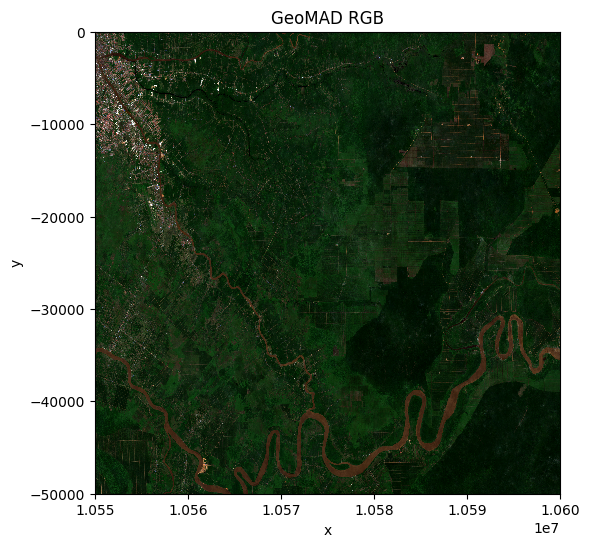

In [6]:
output_dir = "/home/jovyan/Indonesia-GeoMAD/notebook/output/x211/y-01/2024--P1Y"
tile_name = "gm_s2_annual_x211y-01_2024--P1Y"

rgba = rioxarray.open_rasterio(f"{output_dir}/{tile_name}_rgba.tif")

rgba.plot.imshow(rgb='band', figsize=(6, 6), robust=True)
plt.title("GeoMAD RGB")
plt.show()

## Process Data with ODC Algo

In [ ]:
ds["scl"].attrs['flags_definition'] =dc.list_measurements().loc['s2_l2a','scl']['flags_definition']
ds["scl"].attrs['flags_definition']

In [ ]:
from odc.algo import enum_to_bool, erase_bad
from odc.algo import mask_cleanup

# Apply the same cloud filter
# Erase Data Pixels for which mask == nodata
mask = ds["scl"]
bad = enum_to_bool(mask, ("no data",))
for cloud_class, c_filter in cloud_filters.items():
    if not isinstance(cloud_class, tuple):
        cloud_class = (cloud_class,)
        cloud_mask = enum_to_bool(mask, cloud_class)
        cloud_mask_buffered = mask_cleanup(cloud_mask, mask_filters=c_filter)
        bad = cloud_mask_buffered | bad

ds = ds.drop_vars(["scl"])
ds = erase_bad(ds, bad)

In [ ]:
from odc.algo import geomedian_with_mads
gm = geomedian_with_mads(ds)

In [ ]:
gm

### Option - use GM plugin to process

In [ ]:
# Use gm plugin to generate GM
# use same configuration as 
gm = StatsGMS2(resampling="nearest", 
               bands=["blue", "green", "red", "nir", "swir16", "swir22"], 
                cloud_filters=cloud_filters,
               work_chunks=(100,100),
)
xx = gm.input_data(task.datasets, task.geobox)
xx = gm.native_transform(xx)
output = gm.reduce(xx)

In [ ]:
output

In [ ]:
#compute
#output = output.compute()

### Load odc-stats run output

In [ ]:
import xarray as xr

#Assume output save in current location
basepath = f"x{x:03d}/y{y:03d}/{year}/gm_s2_x{x:03d}y{y:03d}_{year}"

bands = ['red', 'green', 'blue']
datasets = [xr.open_dataset(f'{basepath}_{band}.tif',chunks ={}).squeeze() for band in bands]
datasets = [ds.rename_vars({list(ds.data_vars)[0]: name}) for ds, name in zip(datasets, bands)]

combined = xr.merge(datasets)
combined

In [ ]:
count = xr.open_dataset(f'{basepath}_COUNT.tif').squeeze().to_array().squeeze()
count.plot.imshow()

In [ ]:
combined.red.plot.imshow(robust=True)